# Speech Understanding 
# Lecture 9: Automatic Speech Recognition

### Mark Hasegawa-Johnson, KCGI

In the last lecture, you learned how to analyze speech using the spectrogram.
Now let's learn how to recognize speech by comparing input spectra to saved training examples.
1. <a href="#section2">Voice activity detection</a>
1. <a href="#section3">Creating an ASR model from training data</a>
1. <a href="#section4">Using the model to recognize test data</a>
1. <a href="#homework">Homework</a>

<a id='section2'></a>

## 1. Voice activity detection

Before we can understand speech, we first have to detect it!  Let's start with the same waveform we used last time:

In [2]:
import librosa
import IPython.display

speech, Fs = librosa.load('train.m4a',sr=8000)
IPython.display.Audio(speech, rate=Fs)


/var/folders/y5/kdcw0kfn2xl71bwrvl50bj1m0000gn/T/ipykernel_39513/2867551030.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a',sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 1.0, 'Recording sampled at 8000 samples/second')

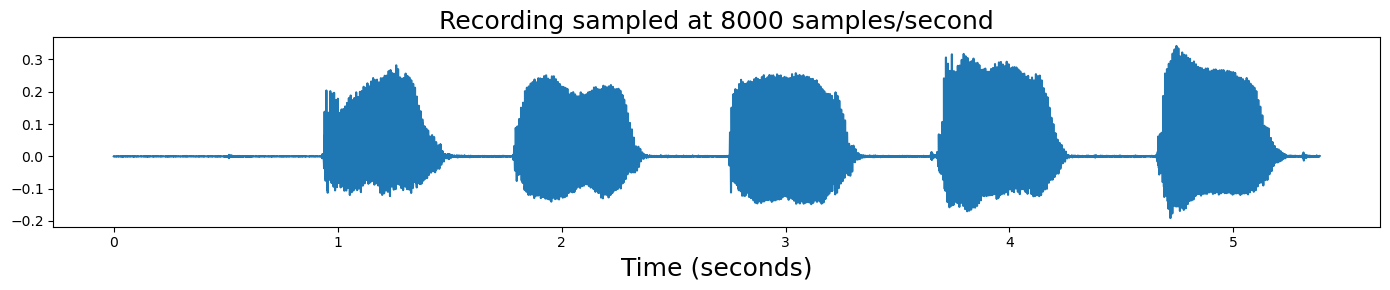

In [3]:
import matplotlib.pyplot as plt
import numpy as np

speech_time_axis = np.arange(len(speech))/Fs

fig = plt.figure(figsize=(14,3),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(speech_time_axis,speech)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.set_title('Recording sampled at %d samples/second'%(Fs),fontsize=18)


* Silence tends to have very small signal values ($x[n]\approx 0$)
* Speech often has much larger signal values ($x[n]\ll 0$ or $x[n]\gg 0$)

In order to distinguish speech from silence, we need to detect values of $x[n]$ that are either much larger than zero or much smaller.  We can do this by taking the absolute value ($|x[n]|$) or by squaring each sample ($x^2[n]$), then averaging in a local window.  A common tool is the **short-time energy**, defined as 

$$E[m]=\sum_{n=m}^{m+N-1} x^2[n]$$

We can compute short time energy as follows:
* Chop the speech into frames
* Calculate the sum of squares of each frame

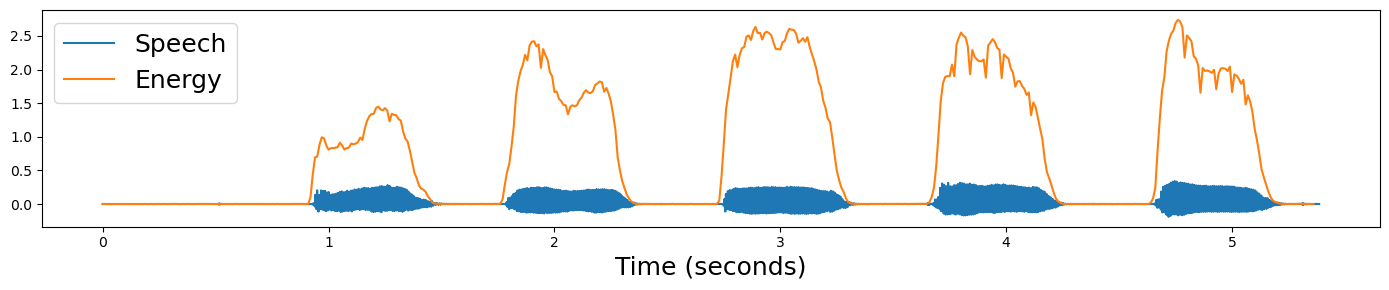

In [4]:
framelength = int(0.025*Fs)
frameskip = int(0.01*Fs)
speech_frames = np.array([ speech[m:m+framelength] for m in range(0,len(speech)-framelength,frameskip) ])

energy = np.sum(np.square(speech_frames), axis=1)
energy_time_axis = np.arange(0,len(speech)-framelength,frameskip) / Fs

fig = plt.figure(figsize=(14,3),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(speech_time_axis,speech, energy_time_axis, energy)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.legend(['Speech','Energy'],fontsize=18)


Notice that different vowels have different energy levels, but all of them are much louder than silence.  **Voice activity detection** (VAD) distinguishes speech from silence, for example, by keeping only the frames that have energy greater than about 10% of the maximum:

$$VAD[m] = \left\{\begin{array}{ll}1 & E[m]> 0.1 \max_m E[m]\\0 & \mbox{otherwise}\end{array}\right.$$

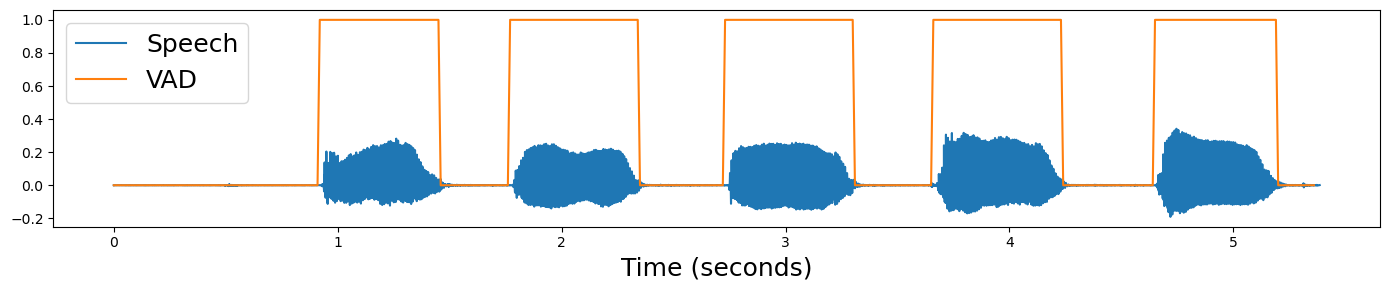

In [7]:
VAD = np.array([ 1 if energy[m]>0.01*max(energy) else 0 for m in range(len(energy)) ])

fig = plt.figure(figsize=(14,3),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(speech_time_axis,speech, energy_time_axis, VAD)
subplot.set_xlabel('Time (seconds)',fontsize=18)
subplot.legend(['Speech','VAD'],fontsize=18)

We can use the VAD to segment the speech into five separate words:

In [9]:
start_times = [ m*frameskip for m in range(1,len(VAD)) if VAD[m-1]==0 and VAD[m]==1 ]
end_times = [ m*frameskip for m in range(1,len(VAD)) if VAD[m-1]==1 and VAD[m]==0 ]
segments = [ speech[start_times[k]:end_times[k]] for k in range(len(start_times)) ]

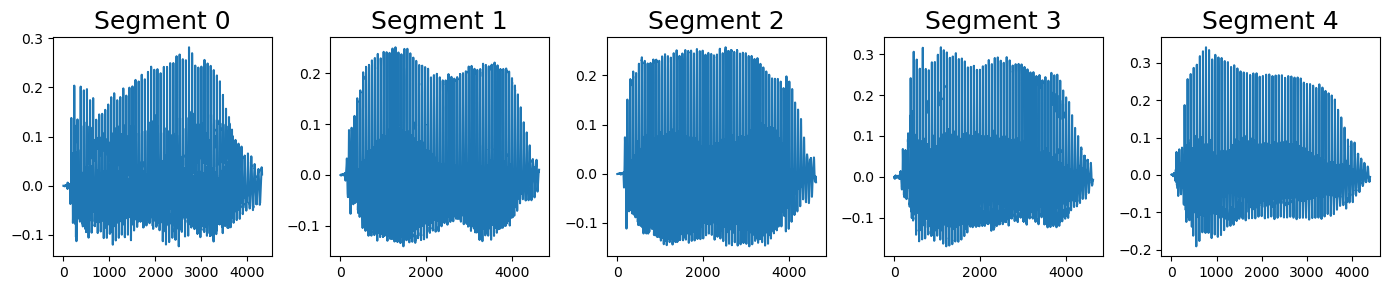

In [10]:
fig = plt.figure(figsize=(14,3),layout='tight')
subplots = fig.subplots(1,5)
for k in range(5):
    subplots[k].plot(segments[k])
    subplots[k].set_title('Segment %d'%(k),fontsize=18)


In [15]:
IPython.display.Audio(segments[4],rate=Fs)

<a id='section3'></a>

## 2. Creating an ASR model from training data

An Automatic Speech Recognizer (ASR) is a piece of software that listens to speech audio, and prints out the corresponding text.  

The core of ASR is a **model**: A model is a description of what each of the different words or phonemes of the language sound like.  The model needs to be represented in some form that allows easy and meaningful comparison between different recordings of the same word: For example, a wideband spectrogram.

A model is created using **training data**.  A training database is a set of waveforms with known text transcriptions. For example, let's use the waveform `speech` as our training data to create models of the speech sounds "a," "i," "u," "e," and "o."

First, let's create a wideband spectrogram of each of the pre-emphasized audio segments:

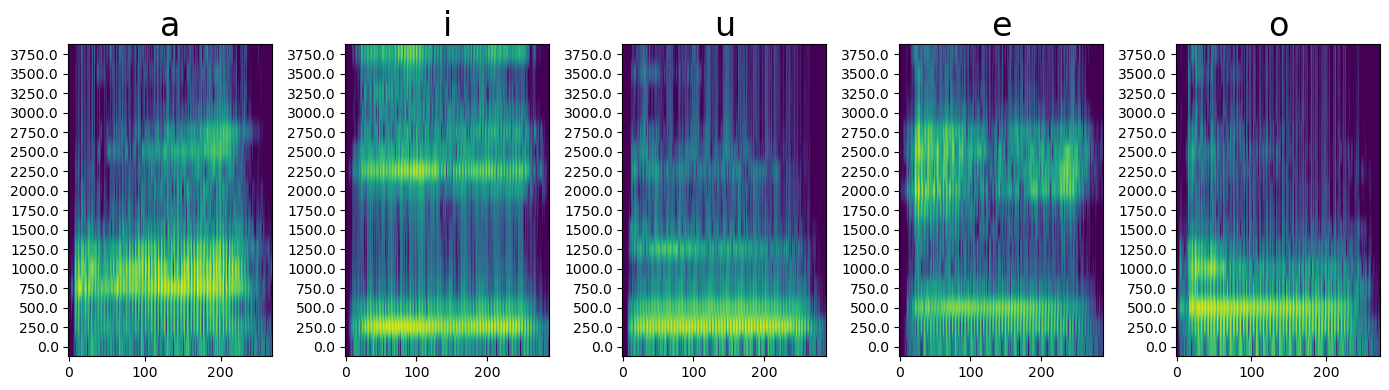

In [16]:
N = int(0.004*Fs)
S = int(0.002*Fs)
fig = plt.figure(figsize=(14,4),layout='tight')
subplots = fig.subplots(1,5)
sgrams = []
frequency_axis = (Fs/N) * np.arange(0,int(N/2))
labels = ['a','i','u','e','o']

for k in range(5):
    x = segments[k]
    frames = np.array([ x[m+1:m+1+N]-x[m:m+N] for m in range(0,len(x)-N,S) ])
    mstft = np.abs(np.fft.fft(frames, axis=1))
    sgrams.append(20*np.log10(np.maximum(0.01*np.amax(mstft),mstft)))
    subplots[k].imshow(sgrams[k][:,0:int(N/2)].transpose(),aspect='auto',origin='lower')
    subplots[k].set_title(labels[k], fontsize=24)
    subplots[k].set_yticks(np.arange(0,int(N/2)), frequency_axis)

A **model** of a speech sound is some description that allows us to recognize it.  For example:

* Define the set of speech sounds to be $y\in\{/a/,/i/,/u/,/e/,/o/\}$
* Define the **feature vector** to be one row of a wideband spectrogram, $X[m,:]$
* Define the **duration** of a vowel, $L[y]$, to be the number of example frames

With those definitions, we can create a model of each vowel by doing something like:

$$M[y] = \frac{1}{L[y]}\sum_{m:Y(m)=y}X[m,:]$$


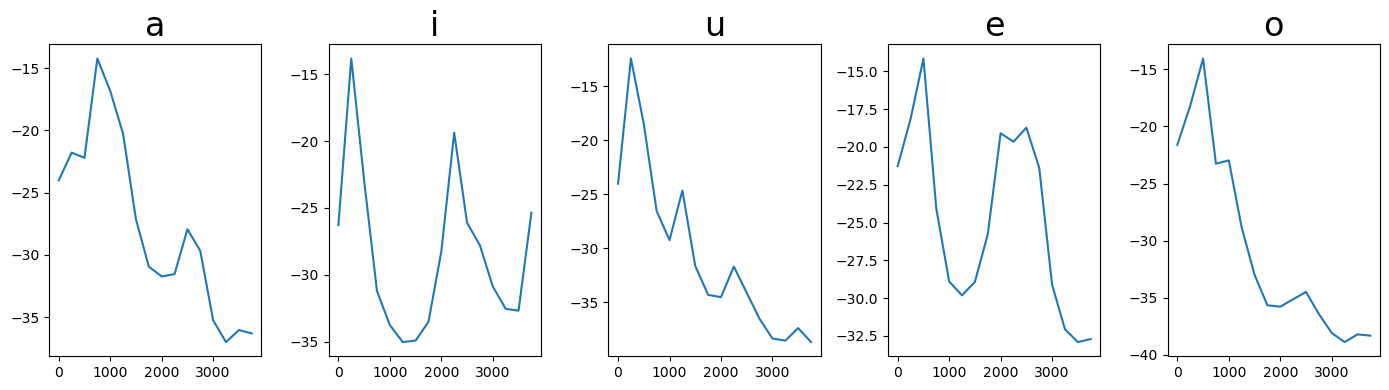

In [17]:
models = [ np.average(sgrams[k][:,0:int(N/2)], axis=0) for k in range(5) ]

fig = plt.figure(figsize=(14,4),layout='tight')
subplots = fig.subplots(1,5)
for k in range(5):
    subplots[k].plot(frequency_axis, models[k] )
    subplots[k].set_title(labels[k], fontsize=24)


Notice how we can see the important differences in shape that we noticed last time:

* /a/ has a broad peak around 1000Hz (it's actually two peaks, at 900 and 1100), and another peak at 2500Hz
* /i/ and /e/ are similar, but:
  * the peaks of /i/ are more extreme (200Hz and 2200Hz)
  * those of /e/ are a little less extreme (400Hz and 2000Hz, plus another at 2500)
* /u/ and /o/ are similar, but:
  * the peaks of /u/ are a little lower (200, 1000, and 2000)
  * those of /o/ are a little higher (400, 1000, and 2500)


<a id='section4'></a>

## 3. Using the model to recognize test data

Now let's read in a new waveform, and try to automatically recognize what it says:

In [18]:
testspeech, Fs = librosa.load('test.m4a',sr=8000)
IPython.display.Audio(testspeech, rate=Fs)

/var/folders/y5/kdcw0kfn2xl71bwrvl50bj1m0000gn/T/ipykernel_39513/515053456.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  testspeech, Fs = librosa.load('test.m4a',sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 1.0, 'Test Speech')

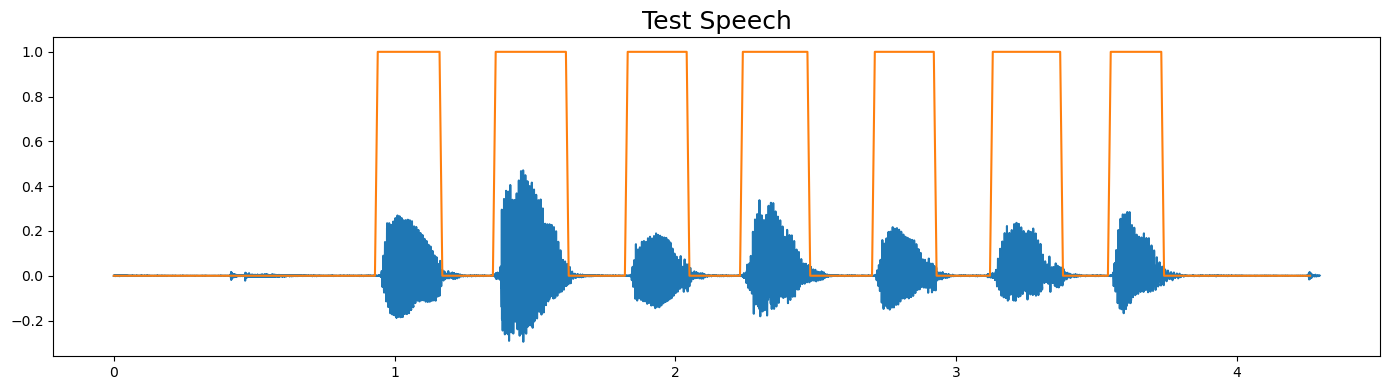

In [20]:
testframes = np.array([ testspeech[m:m+framelength] for m in range(0,len(testspeech)-framelength,frameskip) ])
testenergy = np.sum(np.square(testframes), axis=1)
testVAD = np.array([ 1 if testenergy[m]>0.01*max(testenergy) else 0 for m in range(len(testenergy)) ])

testspeech_times = np.arange(len(testspeech)) / Fs
testVAD_times = np.arange(len(testVAD)) * frameskip / Fs
fig = plt.figure(figsize=(14,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.plot(testspeech_times, testspeech, testVAD_times, testVAD)
subplot.set_title('Test Speech',fontsize=18)

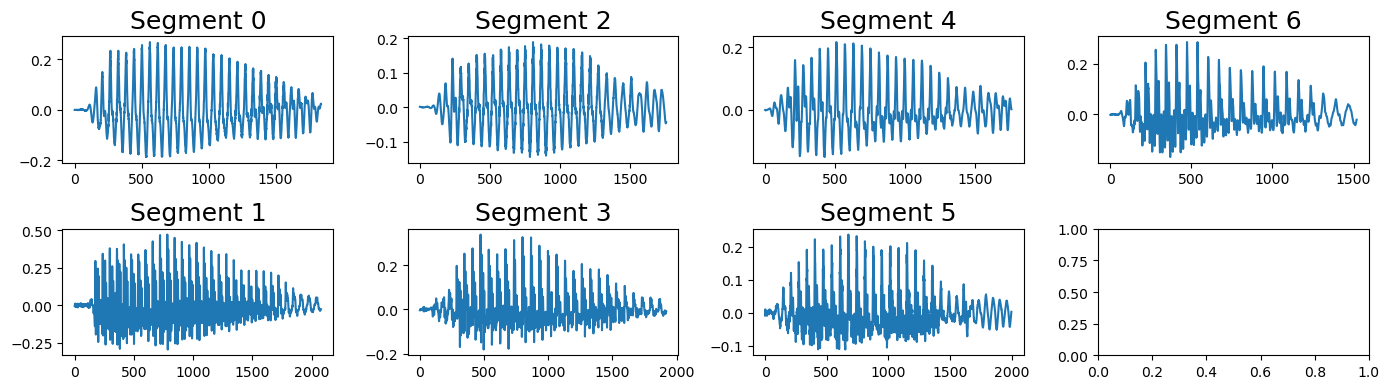

In [21]:
teststart = [ m*frameskip for m in range(1,len(testVAD)) if testVAD[m-1]==0 and testVAD[m]==1 ]
testend = [ m*frameskip for m in range(1,len(testVAD)) if testVAD[m-1]==1 and testVAD[m]==0 ]
testsegments = [ testspeech[teststart[k]:testend[k]] for k in range(len(teststart)) ]

fig = plt.figure(figsize=(14,4),layout='tight')
subplots = fig.subplots(2,int(np.ceil(len(testsegments)/2)))
for k in range(len(testsegments)):
    subplots[k%2,k//2].plot(testsegments[k])
    subplots[k%2,k//2].set_title('Segment %d'%(k),fontsize=18)

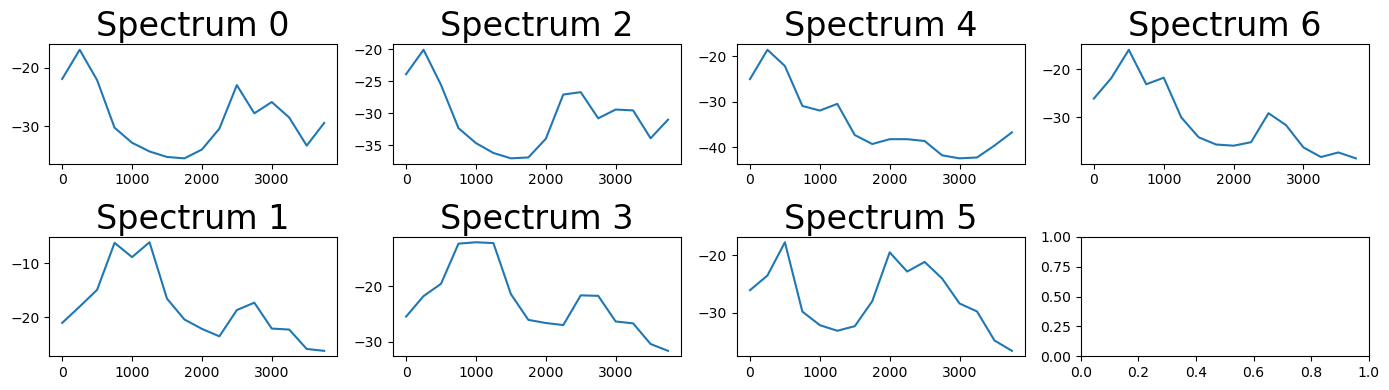

In [22]:
testspectra = []

fig = plt.figure(figsize=(14,4),layout='tight')
subplots = fig.subplots(2,int(np.ceil(len(testsegments)/2)))

for k in range(len(testsegments)):
    x = testsegments[k]
    frames = np.array([ x[m+1:m+1+N]-x[m:m+N] for m in range(0,len(x)-N,S) ])
    mstft = np.abs(np.fft.fft(frames, axis=1))
    sgram = 20*np.log10(np.maximum(0.01*np.amax(mstft),mstft))
    testspectra.append( np.average(sgram[:,0:int(N/2)], axis=0 ) )
    subplots[k%2,k//2].plot(frequency_axis, testspectra[k])
    subplots[k%2,k//2].set_title('Spectrum %d'%(k), fontsize=24)


### Speech recognition using cosine similarity

Now let's try to recognize these spectra!  For recognition, we will use a measure of similarity called **cosine similarity**.  Here's a picture that describes the main idea behind cosine similarity:

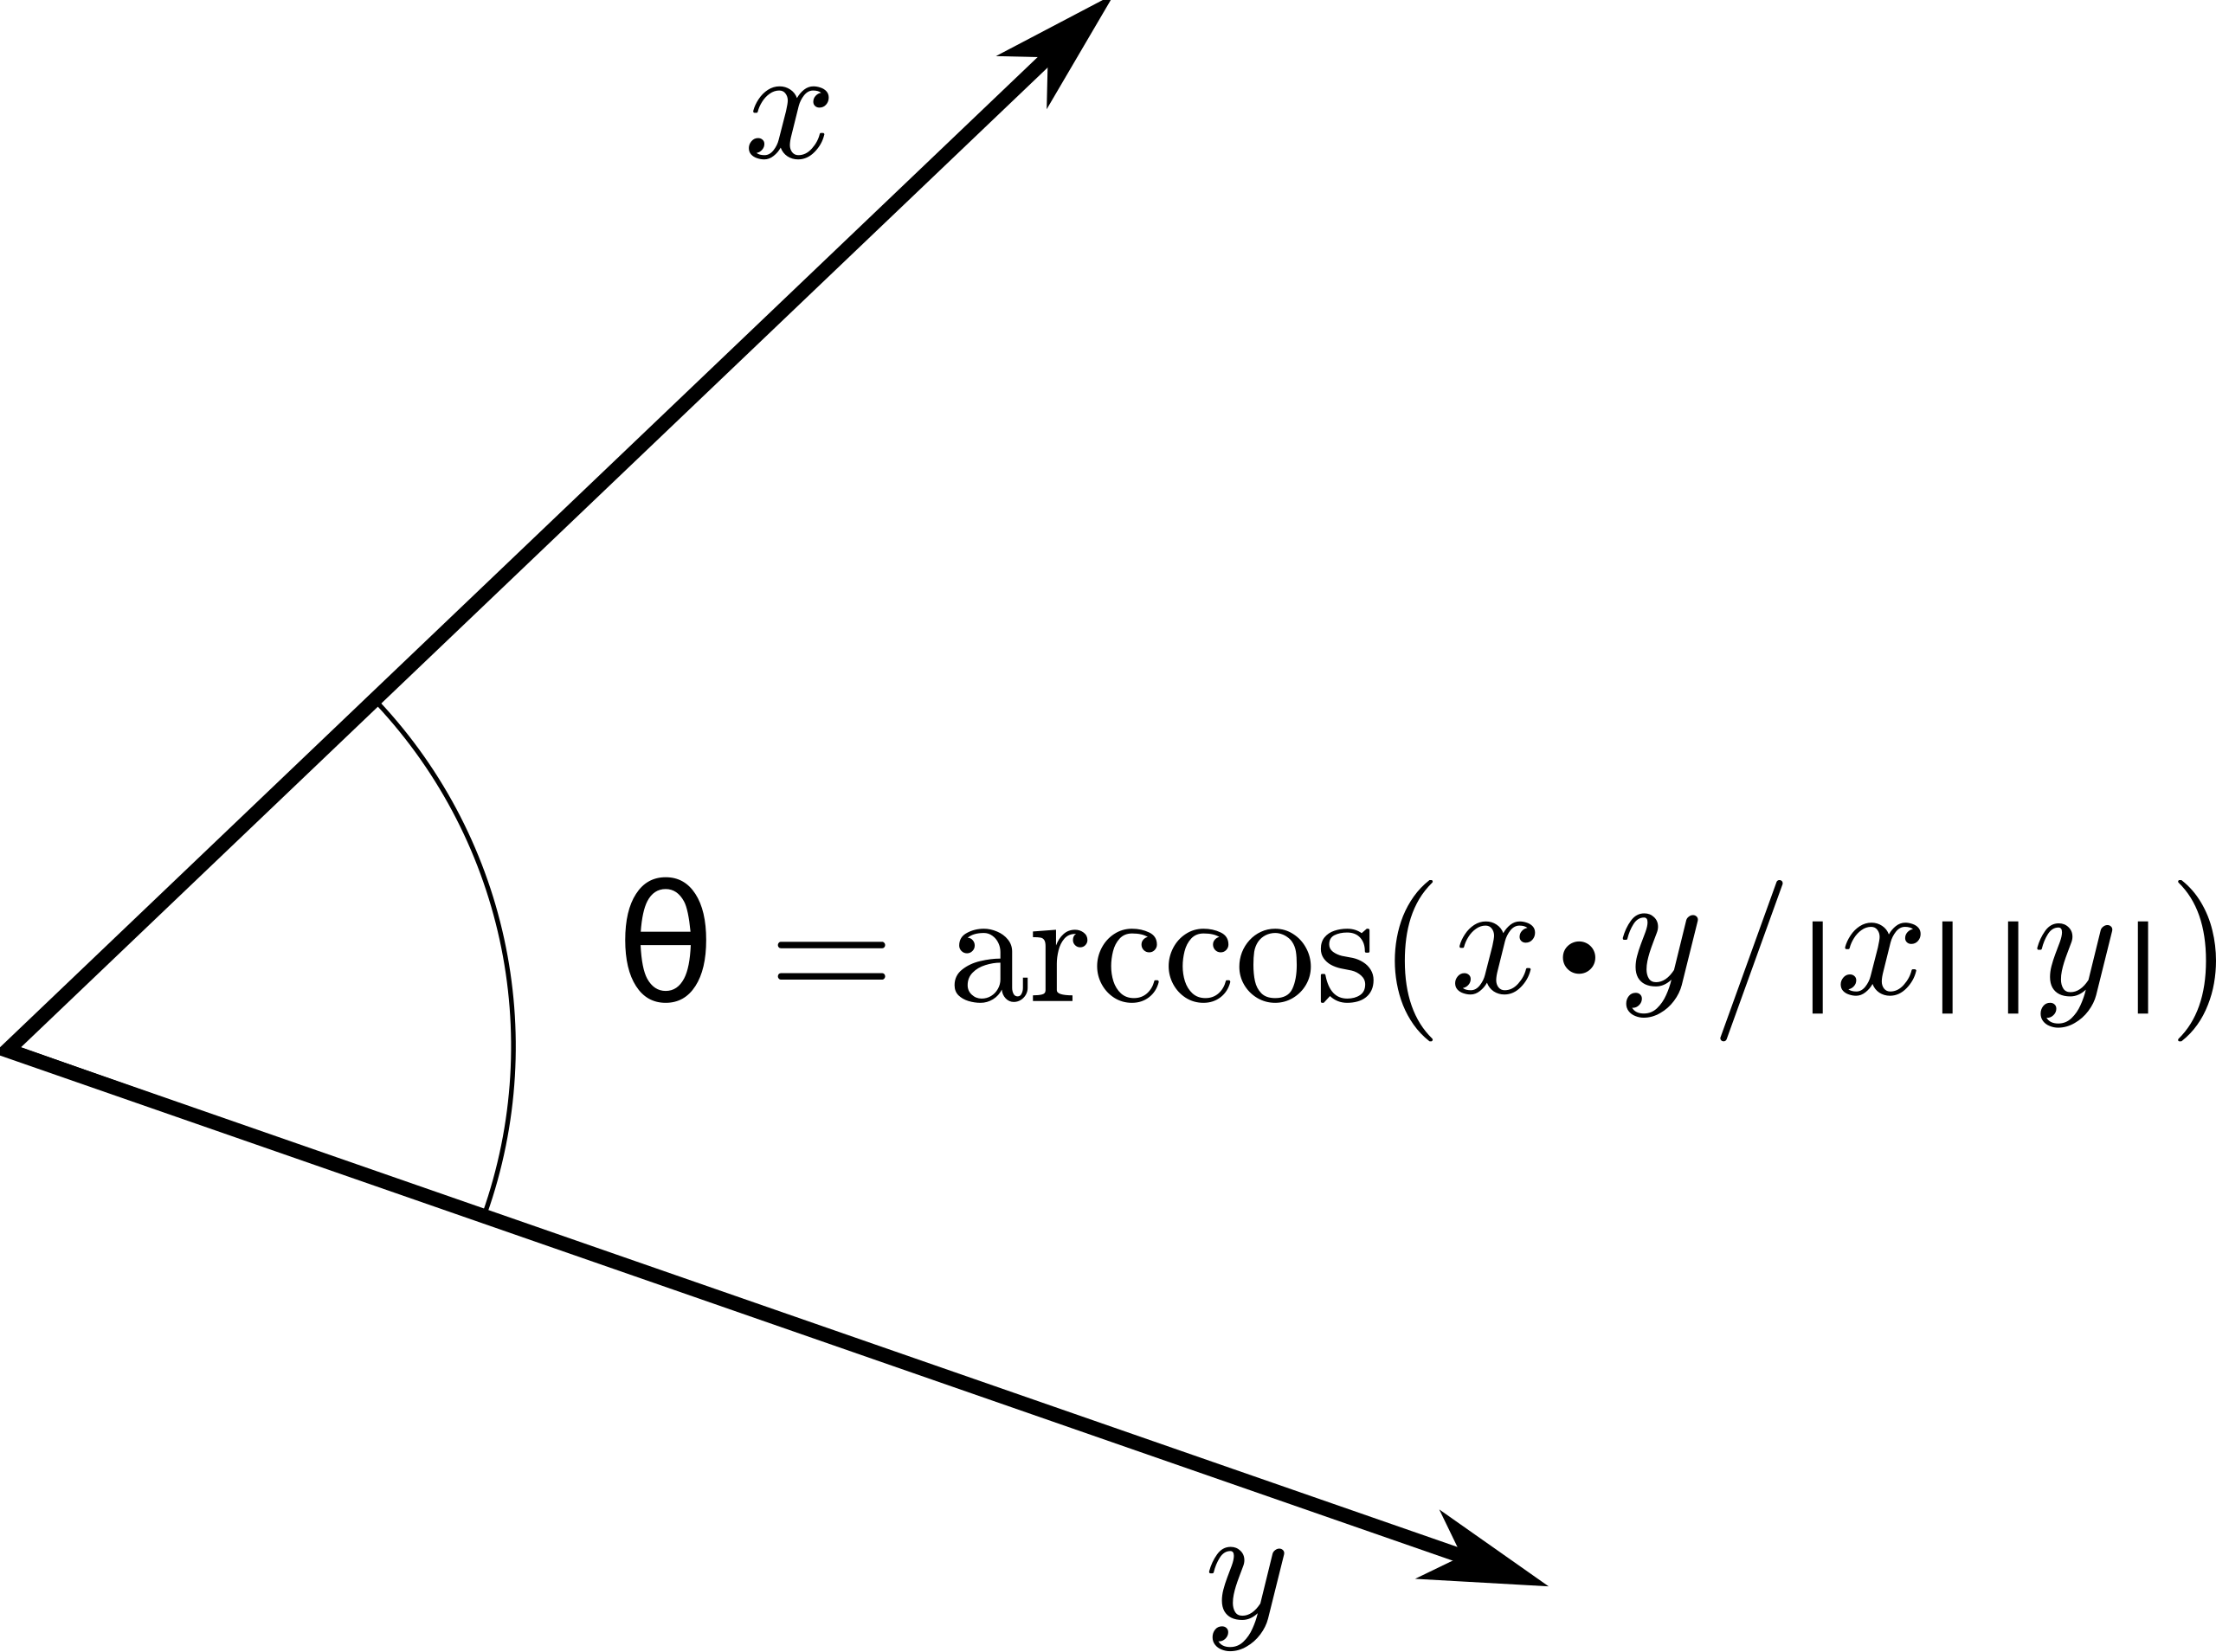

The idea is to treat each spectrum as a vector, and to compute the cosine of the angle between those two vectors.  If the cosine is $\approx 1$, then the two vectors are similar.  If the cosine is $\ll 1$, then the two vectors are different.

Suppose we have two spectra: $\mathbf{x}[k]$ is the spectrum of the $k^{\text{th}}$ test segment, and $\mathbf{m}[y]$ is the spectrum of the $y^{\textrm{th}}$ model.  We want to calculate the cosine of the angle between them:

$$\cos\theta= \frac{\mathbf{x}[k]^T\mathbf{m}[y]}{\vert\mathbf{x}[k]\vert\vert\mathbf{m}[y]\vert}$$

where $\mathbf{x}^T\mathbf{m}=\sum_i x[i]m[i]$ is their dot product, and $\vert\mathbf{x}\vert=\sqrt{\sum_i x^2[i]}$ is the length of the vector.

Text(0.5, 1.0, 'Test-Model Similarities')

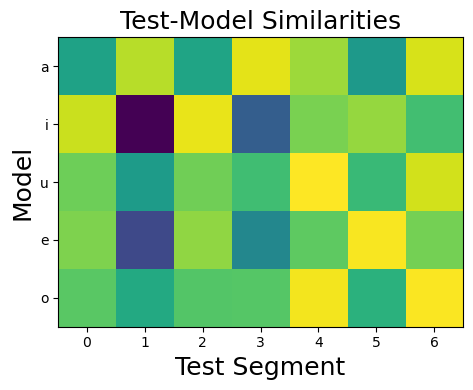

In [23]:
cosines = np.zeros((len(models), len(testsegments)))
for y in range(len(models)):
    for k in range(len(testspectra)):
        x = testspectra[k]
        m = models[y]
        cosines[y,k] = np.dot(x,m) / (np.sqrt(np.sum(np.square(x)))*np.sqrt(np.sum(np.square(m))))

fig = plt.figure(figsize=(6,4),layout='tight')
subplot = fig.subplots(1,1)
subplot.imshow(cosines)
subplot.set_xlabel('Test Segment',fontsize=18)
subplot.set_ylabel('Model',fontsize=18)
subplot.set_yticks(np.arange(5), labels)
subplot.set_title('Test-Model Similarities',fontsize=18)

Based on these similarities, it looks like the "i a i a" part will be correctly recognized, but it's not obvious whether the "u" and "o" will be correctly recognized.  Let's find out: let's look for the model that is most similar to each test segment.

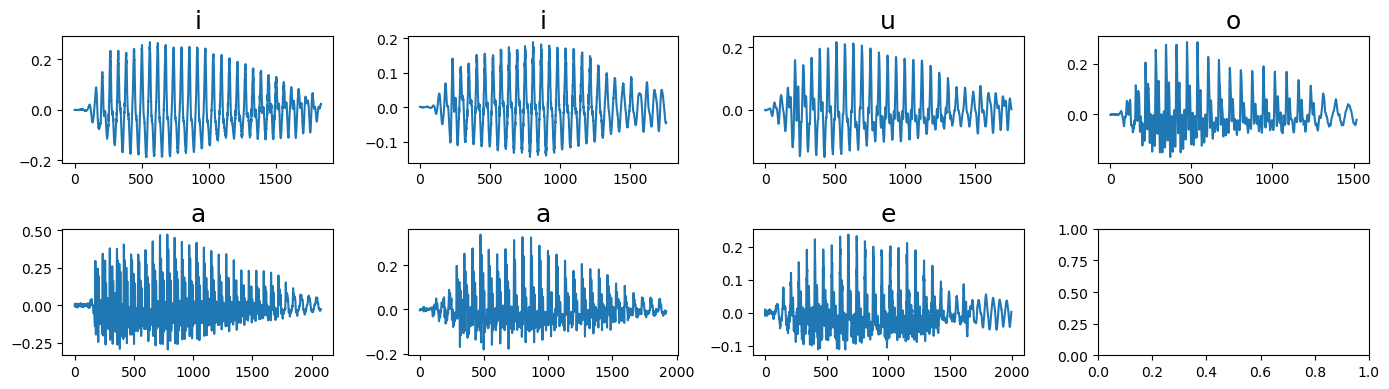

In [24]:
test_output = [ labels[np.argmax(cosines[:,k])] for k in range(len(testspectra)) ]

fig = plt.figure(figsize=(14,4),layout='tight')
subplots = fig.subplots(2,int(np.ceil(len(testsegments)/2)))
for k in range(len(testsegments)):
    subplots[k%2,k//2].plot(testsegments[k])
    subplots[k%2,k//2].set_title(test_output[k],fontsize=18)


<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  Edit the file in this directory called `homework9.py`.  

### Homework 9.1

In [25]:
import importlib, homework9
importlib.reload(homework9)
help(homework9.VAD)

Help on function VAD in module homework9:

VAD(waveform, Fs)
    Extract the segments that have energy greater than 10% of maximum.
    Calculate the energy in frames that have 25ms frame length and 10ms frame step.

    @params:
    waveform (np.ndarray(N)) - the waveform
    Fs (scalar) - sampling rate

    @returns:
    segments (list of arrays) - list of the waveform segments where energy is
       greater than 10% of maximum energy



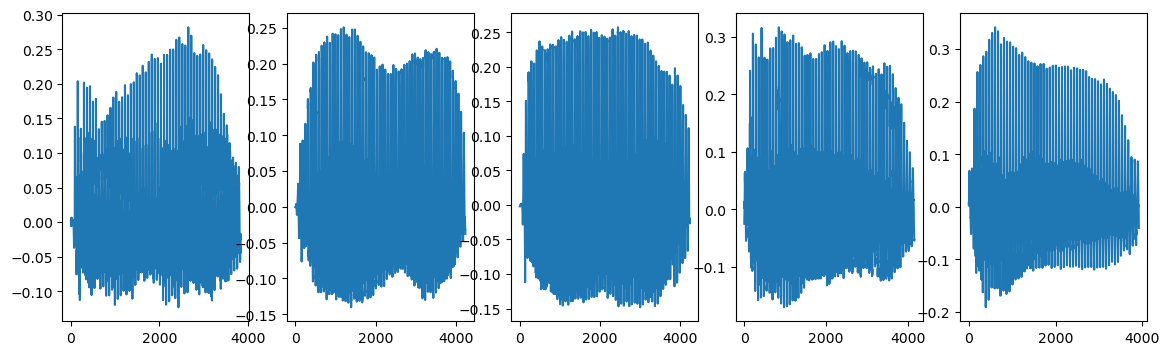

In [28]:
importlib.reload(homework9)
segments = homework9.VAD(speech, Fs)
fig = plt.figure(figsize=(14,4))
subplots = fig.subplots(1,5)
for k in range(5):
    subplots[k].plot(segments[k])


### Homework 9.2: segments_to_model

In [29]:
importlib.reload(homework9)
help(homework9.segments_to_models)

Help on function segments_to_models in module homework9:

segments_to_models(segments, Fs)
    Create a model spectrum from each segment:
    Pre-emphasize each segment, then calculate its spectrogram with 4ms frame length and 2ms step,
    then keep only the low-frequency half of each spectrum, then average the low-frequency spectra
    to make the model.

    @params:
    segments (list of arrays) - waveform segments that contain speech
    Fs (scalar) - sampling rate

    @returns:
    models (list of arrays) - average log spectra of pre-emphasized waveform segments



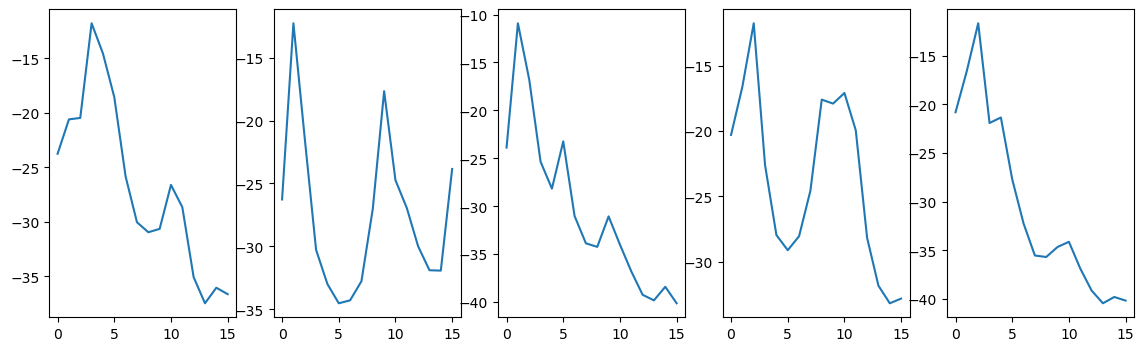

In [31]:
importlib.reload(homework9)
models = homework9.segments_to_models(segments, Fs)
fig = plt.figure(figsize=(14,4))
subplots = fig.subplots(1,5)
for k in range(5):
    subplots[k].plot(models[k])

### Homework 9.3: recognize_speech

In [32]:
importlib.reload(homework9)
help(homework9.recognize_speech)

Help on function recognize_speech in module homework9:

recognize_speech(testspeech, Fs, models, labels)
    Chop the testspeech into segments using VAD, convert it to models using segments_to_models,
    then compare each test segment to each model using cosine similarity,
    and output the label of the most similar model to each test segment.

    @params:
    testspeech (array) - test waveform
    Fs (scalar) - sampling rate
    models (list of Y arrays) - list of model spectra
    labels (list of Y strings) - one label for each model

    @returns:
    sims (Y-by-K array) - cosine similarity of each model to each test segment
    test_outputs (list of strings) - recognized label of each test segment



Recognized outputs are: ['i', 'a', 'i', 'a', 'u', 'e', 'o']


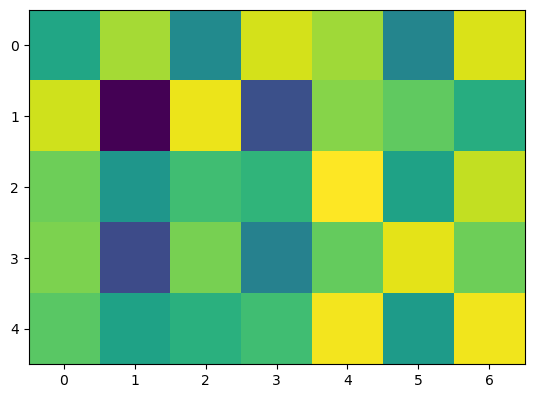

In [45]:
importlib.reload(homework9)
sims, test_outputs = homework9.recognize_speech(testspeech, Fs, models, labels)
#print(sims)
plt.imshow(sims)
print('Recognized outputs are:',test_outputs)

### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [46]:
import importlib, grade
importlib.reload(grade)

/Users/jhasegaw/kcgi/intro_speech_understanding/lec09/grade.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a', sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/jhasegaw/kcgi/intro_speech_understanding/lec09/grade.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  testspeech, Fs = librosa.load('test.m4a', sr=8000)
...
----------------------------------------------------------------------
Ran 3 tests in 0.115s

OK
/Users/jhasegaw/kcgi/intro_speech_understanding/lec09/grade.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  speech, Fs = librosa.load('train.m4a', sr=8000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core

3 successes out of 3 tests run
Score: 100%
3 successes out of 3 tests run
Score: 100%


<module 'grade' from '/Users/jhasegaw/kcgi/intro_speech_understanding/lec09/grade.py'>

Once you've got it working, `git commit` then `git push` to your own repository on github, then copy and paste the URL to Canvas.